
## Convolutional Neural Networks for classification


### for Dog/Human_classification + Dog_Breed prediction + Human Image most resemble dog_breed

## cv2 + transfer_learning

In this notebook, you will make an Algorithm which could be used as part of a mobile or web app by `freezing` our model.

At the end, our model take image as input and then :
- First it will classify weather our image is of dog or human
- If a dog is detected in the image, it will provide the prediction of the dog's breed and 
- if a human is detected it will give us estimate of the most resemble dog breed



### Contents

* step 0: Import Datasets
* step 1: Detect Humans
* step 2: Detect Dogs
* step 3: Create a CNN to Classify Dog Breeds (from Scratch)
* step 4: Use a CNN to Classify Dog Breeds (using Transfer Learning - VGG-NET)
* step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning - RESNET)
* step 6: Write your Algorithm
* step 7: Test Your Algorithm

---
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images
- `train_files, valid_files, test_files`- numpy arrays containing file paths to images
- `train_targets, valid_targets, test_targets `- numpy arrays containing onehot-encoded classification labels 

In [4]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from glob import glob
from helper_functions import load_targets , dog_names_dict

# function to load datasets
def load_files(path):    
    dog_files = np.array(glob.glob(path))
    dog_targets = load_targets(dog_files)
    return dog_files, dog_targets

dog_names = dog_names_dict()

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/home/rushil/Downloads/dog/Images/trains/*/*.jpg')
valid_files, valid_targets = load_dataset('/home/rushil/Downloads/dog/Images/validation/*/*.jpg')
test_files, test_targets = load_dataset('/home/rushil/Downloads/dog/Images/test/*/*.jpg')


# # some stats about the dataset
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 8351 total dog images.
There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

 Importing dataset of human images, Path files of human are stored in array `human_files`.

In [2]:
import random
random.seed(8675309)

human_files = np.array(glob.glob('/home/rushil/Downloads/dog/human/*.jpg'))

print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
## Step 1: Detect Humans

To detect face, we will use opencv Haar feature-based cascade classifiers  in images . 
![](https://matthewearl.github.io/assets/inverse-haar/major_opt.gif)


Number of faces detected: 1


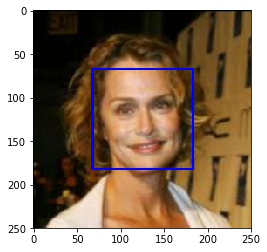

In [19]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('home/rushil/Downloads/dog/haarcascades/haarcascade_frontalface_alt.xml')

# load color image,it will be in BGR
img = cv2.imread(human_files[3])

# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bottom left, bottom right, width , hight for box bounding the face
for (x,y,w,h) in faces:
    # bounding box over our image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(cv_rgb)
plt.show()


### Write a Human Face Detector

Function to return `True` if a human face is detected in a image and `False` otherwise.  This function, `face_detector`, takes a file path to an image as input.

In [20]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Human Face Detector

To test the performance of the `face_detector` function. 

- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 


In [21]:
## take some small amout of files for testing purpose

human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

count1=0
count2=0
for human in human_files_short:
    if face_detector(human):
        count1+=1
for dog in dog_files_short:
    if face_detector(dog):
        count2+=1
print('{}% of the 100 images in human_files have a detected human face'.format(count1))
print('{}% of the 100 images in dog_files have a detected human face'.format(count2))

98% of the 100 images in human_files have a detected human face
11% of the 100 images in dog_files have a detected human face


This algorithm detects human only when a `clear view of a face` is present. This can be useful, for example, in face detection used in cameras.

On the other hand, if one is  trying to detect if a human is present in a photo, the algorithm should be able to detect the person no matter which direction the person is facing.

- I think an algorithm using CNN can be used to detect humans without the having a clear face. Face images from different angles (`Data/Image Augmentation`) can be used to train the algorithm. 

Or some better object detector from OpenCV can be used to detect human images in your algorithm such as `HOG (Histogram of Object Gradient) detector, selective search`, etc.

---
## Step 2: Detect Dogs

In this section, we use ResNet-50 model of ImagNet competition to detect dogs in images. ImageNet contains images of 1000 different categories.  Given an image, this  ResNet-50 model returns a prediction (but only from the available categories in ImageNet) for the object that is contained in the image.

In [23]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data



Preprocess our `input` data for CNN , which require a 4D array
$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where nb_samples corresponds to the total number of images (or samples)  

where channels corresponds to the number of channels present in the images generall 3 for RGB image or 1 for Grayscale  


The `path_to_tensor` function below takes a file path of image as input, returns 4D array or tensor    

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes array of sevral image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$



In [24]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    
    # loads RGB image 
    img = image.load_img(img_path, target_size=(224, 224))
    
    # Image to 3D array  (224, 224, 3)
    x = image.img_to_array(img)
    
    # convert 3D array to 4D array/tensor(1, 224, 224, 3)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Before applying Resent-50 model, some more works need to be done on our 4D array/tensor of images. which can be done by applying `preprocess_input`
    - its convert our RGB image to BGR format, normalise our pixels and etc.

After all preprocessing we are now ready to use the model to extract the predictions. This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability of the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [ helper_function.py file's dog_name() function ](https://github.com/rushil83/DogBreed_Classifier_with_DogHuman_Classifier/blob/master/helper_function.py ). 

In [25]:
from keras.applications.resnet50 import preprocess_input

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dog dictionary](https://github.com/rushil83/DogBreed_Classifier_with_DogHuman_Classifier/blob/master/helper_function.py) , one can notice that all dogs breed are  continuous in the ImageNet categories list i.e. in between 151-268, from `'Chihuahua'` to `'Mexican hairless'`.

So here  `dog_detector` function can help in detecting wheather the image is of a dog or not according to our Resnet-50 model. This function returns `True` if a dog is detected in an image.

## only detect the dog
![](http://selmandesign.com/wp-content/uploads/2016/12/SelmanDesign_Q-A_CATorDOG-flow.gif)

In [26]:
### returns "True" if a dog is detected in the image 
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Implementaion / Test of  the Dog Detector

- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?



In [27]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short

count1=0
count2=0
for human in human_files_short:
    if dog_detector(human):
        count1+=1
for dog in dog_files_short:
    if dog_detector(dog):
        count2+=1
print('{}% of the 100 images in human_files have a detected dog'.format(count1))
print('{}% of the 100 images in dog_files have a detected dog'.format(count2))

1% of the 100 images in human_files have a detected dog
100% of the 100 images in dog_files have a detected dog


---
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ we are not using transfer learning yet).

This process gonna take alot of time as their wil large number trainable parameters in this CNN.

## CNN
![](https://raw.githubusercontent.com/iamaaditya/iamaaditya.github.io/master/images/conv_arithmetic/full_padding_no_strides_transposed.gif)

### Pre-process the Data

We will rescale the images by dividing every pixel in every image by 255( it helps(?)).

In [28]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:23<00:00, 35.35it/s]


###  Model Architecture


- This architecture uses three convolution layers, each followed by a max pooling layer. The convolution layers have increasing numbers of filters, which increases the depth dimension of the output, and the maxpooling layers. This is followed by a global pooling layer. The final result has a high depth dimension and low width and length dimension. This method reduces the spatial information in the original photos, and picks out the characters such as eyes, tails of the dogs. Finally, a dense layer is used to predict the dog breed based on these characters using the "softmax" activation i.e. the one having highest probability in softmax.

![](https://adeshpande3.github.io/assets/LeNet.png)

In [29]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2,activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2,activation='relu'))
model.add((MaxPooling2D(pool_size=2)))
model.add(Conv2D(filters=64, kernel_size=2,activation='relu'))
model.add((MaxPooling2D(pool_size=2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(133,activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_7 ( (None, 64)                0         
__________

### Train the Model

Train your model in the code cell below.model checkpointing is used to save the model weights on iteration.

![](https://www.yayomg.com/wp-content/uploads/2015/08/yayomg-we-bare-bears-gif-computer.gif)

In [31]:
from keras.callbacks import ModelCheckpoint  

### number of epochs to use to train the model.

epochs = 10

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 473s - loss: 4.8826 - acc: 0.0097 - val_loss: 4.8625 - val_acc: 0.0144
Epoch 2/10
6680/6680 [==============================] - 428s - loss: 4.8438 - acc: 0.0154 - val_loss: 4.8271 - val_acc: 0.0144
Epoch 3/10
6680/6680 [==============================] - 385s - loss: 4.7982 - acc: 0.0178 - val_loss: 4.7976 - val_acc: 0.0228
Epoch 4/10
6680/6680 [==============================] - 438s - loss: 4.7669 - acc: 0.0213 - val_loss: 4.7676 - val_acc: 0.0168
Epoch 5/10
6680/6680 [==============================] - 435s - loss: 4.7357 - acc: 0.0222 - val_loss: 4.7462 - val_acc: 0.0216
Epoch 6/10
6680/6680 [==============================] - 432s - loss: 4.7045 - acc: 0.0247 - val_loss: 4.7354 - val_acc: 0.0299
Epoch 7/10
6680/6680 [==============================] - 416s - loss: 4.6771 - acc: 0.0287 - val_loss: 4.7087 - val_acc: 0.0287
Epoch 8/10
6680/6680 [==============================] - 420s - l

### Load the Model with the Best Validation Loss

In [32]:
model.load_weights('/home/rushil/Downloads/dog/saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.

In [33]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 3.3493%


---
## Step 4: Use a CNN to Classify Dog Breeds ( using VGG16)

With the help of transfer learning we can reduce our training time and also increase our accuracy

![vgg16](http://book.paddlepaddle.org/03.image_classification/image/vgg16.png)

### Obtain Bottleneck Features

Here we will use `bottleneck features` (the last activation maps before the fully-connected layers) and develop our own fully connected layers according to classes we have.

In [34]:
bottleneck_features = np.load('/home/rushil/Downloads/dog/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

Here we use the pre-trained VGG_16 model to get our last activation/feature map, and this is used as input to our global average pooling layer and then a fully connected layer is added and lastly softmax actuvation to get the probability of the dog categories.

In [35]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_8 ( (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Train the Model

In [37]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 5s - loss: 12.8375 - acc: 0.1067 - val_loss: 11.4906 - val_acc: 0.1976
Epoch 2/20
6680/6680 [==============================] - 2s - loss: 10.9223 - acc: 0.2478 - val_loss: 10.8195 - val_acc: 0.2467
Epoch 3/20
6680/6680 [==============================] - 2s - loss: 10.4125 - acc: 0.3013 - val_loss: 10.5632 - val_acc: 0.2898
Epoch 4/20
6680/6680 [==============================] - 2s - loss: 10.2481 - acc: 0.3289 - val_loss: 10.4338 - val_acc: 0.3006
Epoch 5/20
6680/6680 [==============================] - 2s - loss: 10.1602 - acc: 0.3472 - val_loss: 10.3870 - val_acc: 0.3102
Epoch 6/20
6680/6680 [==============================] - 2s - loss: 10.1202 - acc: 0.3542 - val_loss: 10.3687 - val_acc: 0.3090
Epoch 7/20
6680/6680 [==============================] - 2s - loss: 10.0068 - acc: 0.3620 - val_loss: 10.2110 - val_acc: 0.3281
Epoch 8/20
6680/6680 [==============================] - 2s - los

### Load the Model with the Best Validation Loss

In [38]:
VGG16_model.load_weights('/home/rushil/Downloads/dog/saved_models/weights.best.VGG16.hdf5')

### Test the Model

Testing time, lets hope its accuracy is greater than 3.349% (which we obtain earlier)

In [41]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)


Test accuracy: 36.2440%


### Predict Dog Breed with the Model

- VGG16_predict_breed to get the name of the dog breed predicted from VGG-16 pretrained model architecture

In [46]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed ehich predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
## Step 5: Create a CNN to Classify Dog Breeds (using ResNet50)

## resnet architecture
![](https://adeshpande3.github.io/assets/ResNet.gif)

###  Obtain Bottleneck Features

In the code block below, extract the bottleneck features  and apply to train, test, and validation sets to get their respective last acitvation map.

In [47]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

###  Model Architecture

Last/Final model architecture is same as of VGG-16 Net one.


In [48]:
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_9 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### Train the Model

Same process as of VGG-16. 

In [51]:
### model training
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s - loss: 1.6350 - acc: 0.5865 - val_loss: 0.8471 - val_acc: 0.7353
Epoch 2/20
6680/6680 [==============================] - 2s - loss: 0.4351 - acc: 0.8624 - val_loss: 0.6802 - val_acc: 0.7976
Epoch 3/20
6680/6680 [==============================] - 2s - loss: 0.2649 - acc: 0.9148 - val_loss: 0.6723 - val_acc: 0.7916
Epoch 4/20
6680/6680 [==============================] - 2s - loss: 0.1760 - acc: 0.9383 - val_loss: 0.7022 - val_acc: 0.8024
Epoch 5/20
6680/6680 [==============================] - 2s - loss: 0.1243 - acc: 0.9606 - val_loss: 0.6733 - val_acc: 0.8144
Epoch 6/20
6680/6680 [==============================] - 2s - loss: 0.0902 - acc: 0.9763 - val_loss: 0.6729 - val_acc: 0.8251
Epoch 7/20
6680/6680 [==============================] - 2s - loss: 0.0666 - acc: 0.9802 - val_loss: 0.6808 - val_acc: 0.8228
Epoch 8/20
6680/6680 [==============================] - 2s - loss: 0.0492 - ac

###  Load the Model with the Best Validation Loss

In [52]:
### Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### Test the Model

Testing time for ResNet50, ReseNet50 has outperformed the VGGNET on the ImageNet challenge, lets hope we get same result here.

In [54]:

# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)



Test accuracy: 78.9474%


## 78.9474% accuracy in resnet , much better than vggnet

![](https://scontent-bom1-1.xx.fbcdn.net/v/t1.0-9/21317412_361459907641849_3081773866256127667_n.png?oh=f191f1b62c5b86e1c9679d23e5c939a2&oe=5AAA6F2F)

### still, resent is better than vggnet

### Predict Dog Breed with the Model

Here funtion `Resnet50_predict_breed` function we return the dog name predicted from our model.

`Resnet50_predict_breed` function  have three steps:

1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  then  argmax of this prediction vector gives the index of the predicted dog breed.
3. Then  argmax of our prediction vector will give the index of the predicted dog breed, Use the `dog_names` dictionaty imported from  the `helper_funtion.py` file to return the corresponding breed.



In [71]:
### function that takes a path to an image as input and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import extract_Resnet50

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Finally our `last function` that accepts file and determines whether the image contains a human or dog.
and then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In this function we will use our eariler defined function `face_detector` and `dog_detector` to specify weather the image is of human or dog and then CNN model develop above to predict the dog breed.



In [125]:

import matplotlib.image as mpimg

def find_inner_dog(imag_path):
    if dog_detector(imag_path):
        print('A dog has been detected!')
        showimag(imag_path)
        print('It looks like a {}!'.format(Resnet50_predict_breed(imag_path)))
    elif face_detector(imag_path):
        print('A person has been detected!')
        showimag(imag_path)
        dogname=Resnet50_predict_breed(imag_path)
        print('This person looks like a {}!'.format(dogname))
        dogfile=glob("dogImages/train/*/{}*".format(dogname))
        showimag(dogfile[0])
    
        
def showimag(imag_path):
    img=mpimg.imread(imag_path)
    imgplot = plt.imshow(img)
    plt.show()

---
## Step 7: Testing  Our Model on sample Images

A dog has been detected!


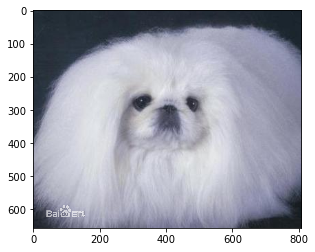

It looks like a Pekingese!


In [136]:
find_inner_dog('/home/rushil/Downloads/dog/myimag/1.png')

A dog has been detected!


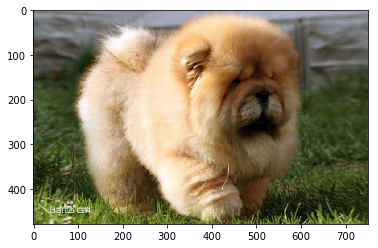

It looks like a Chow_chow!


In [137]:
find_inner_dog('/home/rushil/Downloads/dog/myimag/2.png')

A dog has been detected!


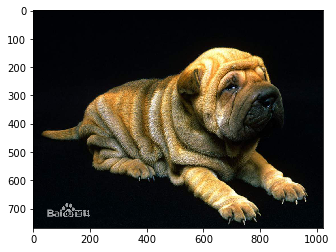

It looks like a Chinese_shar-pei!


In [138]:
find_inner_dog('/home/rushil/Downloads/dog/myimag/3.jpg')

A person has been detected!


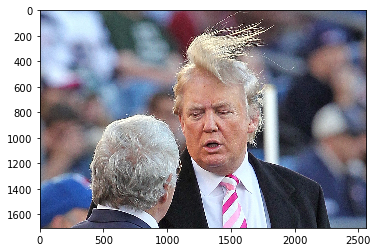

This person looks like a Poodle!


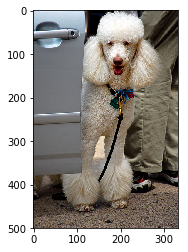

In [141]:
find_inner_dog('/home/rushil/Downloads/dog/myimag/4.jpg')

A person has been detected!


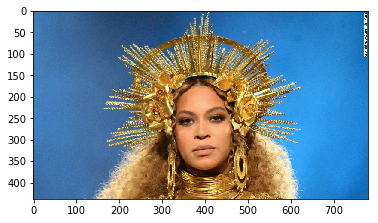

This person looks like a Afghan_hound!


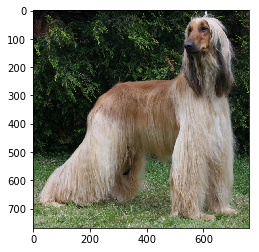

In [129]:
find_inner_dog('/home/rushil/Downloads/dog/myimag/5.jpg')

A person has been detected!


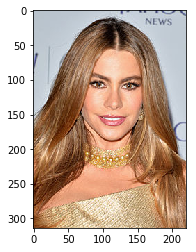

This person looks like a Maltese!


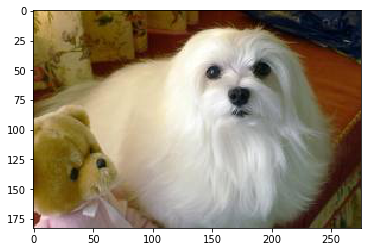

In [134]:
find_inner_dog('/home/rushil/Downloads/dog/myimag/6.jpg')